In [2]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt
import statsmodels.formula.api as sm

In [3]:
train = pd.read_csv("data/2022_FH.csv")
train = train.dropna(subset = ["Game Prep"])
train.reset_index()
names_to_remove = ["Florien Marcussen", "Erica Hootstein", "Caroline Hughes", "Abby Renaud"]
remove = ~train["Athlete"].isin(names_to_remove)
train = train[remove].reset_index(drop=True)

/var/folders/f5/v23gj0gj0_jc4w26rhk8n_100000gn/T/ipykernel_4336/203172586.py:1: DtypeWarning: Columns (59,63,67) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("data/2022_FH.csv")


In [6]:
train.columns

Index(['Week', 'Day', 'W L', 'Game Prep', 'Position', 'Athlete',
       'Session Name', 'Session', 'Phase Name', 'Duration', 'Date', 'HR Min',
       'HR AVG', 'HR Max', 'HR Min Per', 'HR Avg Per', 'HR Max Per', 'HR 1',
       'HR 2', 'HR 3', 'HR 4', 'HR 5', 'Total Distance', 'Distance/min',
       'Max Speed', 'Avg Speed', 'Sprints', 'Speed 1', 'Speed 2', 'Speed 3',
       'Speed 4', 'Speed 5', 'Decel 4', 'Decel 3', 'Decel 2', 'Decel 1',
       'Accel 1', 'Accel 2', 'Accel 3', 'Accel 4', 'Calories', 'TLScore',
       'Cardio Load', 'Recovery', 'TL Percent', 'TLScore Acute',
       'TLScore Chronic', 'TLScore TSB', 'HR Sum 4-5', 'Acute HR Sum',
       'Chronic HR Sum', 'TSB HR Sum', 'TD Percent', 'Acute TD', 'Chronic TD',
       'TSB TD', 'HIA', 'Acute HIA', 'Chronic HIA', 'TSB HIA', 'HSD',
       'Acute HSD', 'Chronic HSD', 'TSB HSD', 'Decel Sum', 'Acute Decel',
       'Chronic Decel', 'TSB Decel', 'HR 4 Percent', 'HR 5 Percent',
       'Percent Above 80', 'TRIMP', 'Duration (min)'],


**Cleaning data**
- delete all rows that aren't preparing for a game
- only use fall data (August - Dec) - regular season data
- don't include HR% because practices are varying length - actual time is more important
- filter to only include "whole session"
- filter to players who played more than 800 minutes for the 2022 season
- filter out goalies

In [7]:
#train = train[["Week", "W L", "Game Prep", "Position", "Athlete", "Session Name", "Phase Name", "Date", "HR Min", "HR AVG", "HR Max", "HR 1", "HR 2", "HR 3", "HR 4", "HR 5", "Total Distance", "Sprints", "Cardio Load", "TLScore", "Duration (min)"]]

In [8]:
train["Date"] = pd.to_datetime(train['Date'])
train.Date

0       2021-08-25
1       2021-08-25
2       2021-08-25
3       2021-08-25
4       2021-08-25
           ...    
22398   2022-11-20
22399   2022-11-20
22400   2022-11-20
22401   2022-11-20
22402   2022-11-20
Name: Date, Length: 16825, dtype: datetime64[ns]

In [9]:
#only keeping whole session, dates during season, and field player data
train = train[(train["Phase Name"] == "Whole session") & (train["Date"] >= "2022-08-01") & (train["Date"] <= "2022-12-01") & (train["Position"] != "GK")]

In [10]:
train.Athlete.unique()

array(['Amelia Albers', 'Bente Baekers', 'Jordan Carr', 'Regan Cornelius',
       'Shannon Daley', 'Sophie Dix', 'Peyton Halsey', 'Lane Herbert',
       'Greta Hinke', 'Lauren Hunter', 'Aerin Krys', 'Ana Medina Garcia',
       'Magnolia Powers', 'Chloe Relford', 'Lila Slattery',
       'Sophie Thomas', 'Lauren Wadas', 'Madeleine Zimmer',
       'Maja Zivojnovic', 'Kayla Blas', 'Alia Marshall', 'Katie Jones'],
      dtype=object)

In [11]:
#filtering out data for only players with minutes above 800 minutes of playing time over the course of the season (total possible playing time around 1600 minutes)
high_min_players = ['Bente Baekers', 'Shannon Daley', 'Peyton Halsey', 'Ana Medina Garcia', 'Chloe Relford', 'Lauren Wadas','Madeleine Zimmer','Kayla Blas','Alia Marshall']
train = train.loc[train.Athlete.isin(high_min_players),:]
train

,Week,Day,W L,Game Prep,Position,Athlete,Session Name,Session,Phase Name,Duration,...,TSB HSD,Decel Sum,Acute Decel,Chronic Decel,TSB Decel,HR 4 Percent,HR 5 Percent,Percent Above 80,TRIMP,Duration (min)
13150,52,Wednesday,NaN,Iowa,F,Bente Baekers,GD-3,Training,Whole session,3:22:48,...,1.00,101.0,32.97,36.74,0.90,23.10%,13.78%,36.88%,1259.05,203
13153,52,Wednesday,NaN,Iowa,B,Shannon Daley,GD-3,Training,Whole session,3:22:48,...,1.00,141.0,33.16,36.50,0.91,17.27%,14.99%,32.26%,1233.70,203
13155,52,Wednesday,NaN,Iowa,M,Peyton Halsey,GD-3,Training,Whole session,3:22:48,...,1.00,65.0,26.11,28.82,0.91,4.92%,8.10%,13.03%,1402.70,203
13161,52,Wednesday,NaN,Iowa,M,Ana Medina Garcia,GD-3,Training,Whole session,3:22:48,...,1.00,110.0,26.75,30.93,0.86,21.54%,7.31%,28.85%,1225.25,203
13163,52,Wednesday,NaN,Iowa,M,Chloe Relford,GD-3,Training,Whole session,3:22:48,...,1.00,148.0,34.63,35.86,0.97,14.52%,20.36%,34.89%,1233.70,203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22260,65,Sunday,L,NCAA_UNC,M,Alia Marshall,NCAA_UNC,Game,Whole session,2:26:00,...,0.97,109.0,30.74,31.71,0.97,37.04%,8.77%,45.81%,906.42,146
22261,65,Sunday,L,NCAA_UNC,M,Ana Medina Garcia,NCAA_UNC,Game,Whole session,2:26:00,...,0.95,111.0,29.15,27.79,1.05,32.74%,22.65%,55.39%,955.08,146
22262,65,Sunday,L,NCAA_UNC,M,Chloe Relford,NCAA_UNC,Game,Whole session,2:26:00,...,1.17,111.0,36.18,32.85,1.1,14.42%,22.09%,36.51%,900.33,146
22265,65,Sunday,L,NCAA_UNC,M,Lauren Wadas,NCAA_UNC,Game,Whole session,2:26:00,...,0.88,88.0,27.36,27.92,0.98,12.90%,8.63%,21.53%,851.67,146


In [12]:
train['W L'].isnull().sum()

40

In [13]:
# dropping all NA W_L values bc that game was a scrimmage
train = train.dropna()
train.head()

,Week,Day,W L,Game Prep,Position,Athlete,Session Name,Session,Phase Name,Duration,...,TSB HSD,Decel Sum,Acute Decel,Chronic Decel,TSB Decel,HR 4 Percent,HR 5 Percent,Percent Above 80,TRIMP,Duration (min)
13879,53,Thursday,W,Maine,F,Bente Baekers,GD-3,Training,Whole session,2:02:28,...,0.94,80.0,32.50,32.66,0.99,22.77%,7.09%,29.86%,699.08,122
13880,53,Thursday,W,Maine,B,Kayla Blas,GD-3,Training,Whole session,2:02:28,...,1.24,62.0,25.67,29.48,0.87,18.02%,0.00%,18.02%,653.16,122
13883,53,Thursday,W,Maine,B,Shannon Daley,GD-3,Training,Whole session,2:02:28,...,0.91,99.0,34.18,34.54,0.99,20.79%,6.76%,27.56%,683.77,122
13885,53,Thursday,W,Maine,M,Peyton Halsey,GD-3,Training,Whole session,2:02:28,...,1.14,65.0,29.62,28.14,1.05,14.02%,26.29%,40.31%,770.52,122
13892,53,Thursday,W,Maine,M,Alia Marshall,GD-3,Training,Whole session,2:02:28,...,1.07,57.0,25.48,26.50,0.96,16.59%,0.14%,16.73%,648.05,122


In [14]:
#adding a binary column for W and Loss
train.columns = train.columns.str.replace(' ', '_')
train['W_L_binary'] = train['W_L'].apply(lambda x: 0 if x=='L' else 1)
train.head()

/var/folders/lg/nhypnqx14z146w17m8kgry7c0000gn/T/ipykernel_61602/1939409511.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['W_L_binary'] = train['W_L'].apply(lambda x: 0 if x=='L' else 1)


,Week,Day,W_L,Game_Prep,Position,Athlete,Session_Name,Session,Phase_Name,Duration,...,Decel_Sum,Acute_Decel,Chronic_Decel,TSB_Decel,HR_4_Percent,HR_5_Percent,Percent_Above_80,TRIMP,Duration_(min),W_L_binary
13879,53,Thursday,W,Maine,F,Bente Baekers,GD-3,Training,Whole session,2:02:28,...,80.0,32.50,32.66,0.99,22.77%,7.09%,29.86%,699.08,122,1
13880,53,Thursday,W,Maine,B,Kayla Blas,GD-3,Training,Whole session,2:02:28,...,62.0,25.67,29.48,0.87,18.02%,0.00%,18.02%,653.16,122,1
13883,53,Thursday,W,Maine,B,Shannon Daley,GD-3,Training,Whole session,2:02:28,...,99.0,34.18,34.54,0.99,20.79%,6.76%,27.56%,683.77,122,1
13885,53,Thursday,W,Maine,M,Peyton Halsey,GD-3,Training,Whole session,2:02:28,...,65.0,29.62,28.14,1.05,14.02%,26.29%,40.31%,770.52,122,1
13892,53,Thursday,W,Maine,M,Alia Marshall,GD-3,Training,Whole session,2:02:28,...,57.0,25.48,26.50,0.96,16.59%,0.14%,16.73%,648.05,122,1


In [15]:
# Changing HR zones to minutes
train['HR_1'] = train['HR_1'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
train['HR_2'] = train['HR_2'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
train['HR_3'] = train['HR_3'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
train['HR_4'] = train['HR_4'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
train['HR_5'] = train['HR_5'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
train['Acute_HR_Sum'] = train['Acute_HR_Sum'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
train['Chronic_HR_Sum'] = train['Chronic_HR_Sum'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))

/var/folders/lg/nhypnqx14z146w17m8kgry7c0000gn/T/ipykernel_61602/4274240502.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['HR_1'] = train['HR_1'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
/var/folders/lg/nhypnqx14z146w17m8kgry7c0000gn/T/ipykernel_61602/4274240502.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['HR_2'] = train['HR_2'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
/var/folders/lg/nhypnqx14z146w17m8kgry7c0000gn/T/ipykernel_61602/4274240502.py

In [16]:
train.corrwith(train.W_L_binary).sort_values(ascending = False)

W_L_binary         1.000000
Chronic_TD         0.089316
TLScore_Chronic    0.080723
HR_AVG             0.054697
HR_Avg_Per         0.054277
Recovery           0.050656
HR_3               0.044949
Chronic_HR_Sum     0.026896
Decel_2            0.023906
Acute_HIA          0.021393
HR_Max_Per         0.020642
HR_Max             0.019570
Chronic_HIA        0.015943
Speed_5            0.014181
TLScore_Acute      0.012378
Accel_4            0.010027
TLScore            0.007662
HIA                0.006607
Accel_3            0.005298
Accel_2            0.003867
HR_4               0.003810
Sprints            0.003068
Accel_1           -0.000331
HSD               -0.000598
Cardio_Load       -0.001973
Max_Speed         -0.006403
HR_5              -0.006763
HR_2              -0.007620
Speed_4           -0.009407
Calories          -0.010086
Decel_3           -0.015878
Acute_HR_Sum      -0.021777
Decel_Sum         -0.022557
TRIMP             -0.026036
Speed_3           -0.026278
HR_Min_Per        -0

In [17]:
## Below here I am playing around with shifting the dataframe. 
# these two lines show that there is an unequal number of observations for each day. 
# I am going to try to fix this by grouping by date and taking the positional avgs for each day. after this, 
# we should be able to shift by date

In [18]:
train.Athlete.value_counts()
train.Date

13879   2022-08-25
13880   2022-08-25
13883   2022-08-25
13885   2022-08-25
13892   2022-08-25
           ...    
22260   2022-11-20
22261   2022-11-20
22262   2022-11-20
22265   2022-11-20
22266   2022-11-20
Name: Date, Length: 674, dtype: datetime64[ns]

# essentially, we need to make a for loop that assess whether each date is in the dataframe in our date range bc off days wont have data and we need to account for that. If the date is not there, we need to insert 3 rows w F M and B data. When creating the new row of data, you need the date and whether it was a W_L at the following game. Otherwise, every observation can be 0.

steps
1. assess if the date appears in train (use TF df)
2. if True, continue (just go to beginning of for loop)
3. if False, add a new row w the Date


In [19]:
len(pd.date_range('08/25/2022','11/20/2022'))

88

In [20]:
len(train.Date.unique())

69

In [21]:
date_range = pd.date_range('08/25/2022','11/20/2022')
#date_range = pd.DataFrame(date_range)
#TF_date_range = 
TF_date_range = pd.DataFrame(date_range.isin(train.Date))
TF_date_range.value_counts()
#date_range

True     69
False    19
dtype: int64

In [22]:
#len(train.Date)
#date_range.isin(train.Date)
train = train.loc[train.Athlete.isin(high_min_players),:]

In [23]:
#train.columns

In [24]:
#T_F = pd.DataFrame(date_range.isin(train.Date))
#T_F.iloc[1,0]
date_range = pd.date_range('08/25/2022','11/20/2022')
date_range = pd.DataFrame(date_range)
pd.DataFrame(date_range.isin(train.Date))

,0
0,False
1,False
2,False
3,False
4,False
...,...
83,False
84,False
85,False
86,False


In [25]:
date_range = pd.date_range('08/25/2022','11/20/2022')
#date_range = pd.DataFrame(date_range)
#TF_date_range = 
TF_date_range = pd.DataFrame(date_range.isin(train.Date))
TF_date_range.value_counts()


#date_range = pd.date_range('08/25/2022','11/20/2022')
#date_range = pd.DataFrame(date_range)
#T_F = pd.DataFrame(date_range.isin(train.Date))

for i in range(len(date_range)):
    a = pd.DataFrame(date_range)
    #print(TF_date_range.iloc[i,0])
    
    if TF_date_range.iloc[i,0] == False:
        
        new_rows = [{'Week':0, 'Day':None, 'W_L':None, 'Game_Prep': None, 'Position':'F', 'Athlete':None,
             'Session_Name':None, 'Session':None, 'Phase_Name':None, 'Duration':0, 'Date':a.iloc[i,0], 'HR_Min':0,
             'HR_AVG':0, 'HR_Max':0, 'HR_Min_Per':0, 'HR_Avg_Per':0, 'HR_Max_Per':0, 'HR_1':0,
             'HR_2':0, 'HR_3':0, 'HR_4':0, 'HR_5':0, 'Total_Distance':0, 'Distance/min':0,
             'Max_Speed':0, 'Avg_Speed':0, 'Sprints':0, 'Speed_1':0, 'Speed_2':0, 'Speed_3':0,
             'Speed_4':0, 'Speed_5':0, 'Decel_4':0, 'Decel_3':0, 'Decel_2':0, 'Decel_1':0,
             'Accel_1':0, 'Accel_2':0, 'Accel_3':0, 'Accel_4':0, 'Calories':0, 'TLScore':0,
             'Cardio_Load':0, 'Recovery':0, 'TL_Percent':0, 'TLScore_Acute':0,
             'TLScore_Chronic':0, 'TLScore_TSB':0, 'HR_Sum_4-5':0, 'Acute_HR_Sum':0,
             'Chronic_HR_Sum':0, 'TSB_HR_Sum':0, 'TD_Percent':0, 'Acute_TD':0, 'Chronic_TD':0,
             'TSB_TD':0, 'HIA':0, 'Acute_HIA':0, 'Chronic_HIA':0, 'TSB_HIA':0, 'HSD':0,
             'Acute_HSD':0, 'Chronic_HSD':0, 'TSB_HSD':0, 'Decel_Sum':0, 'Acute_Decel':0,
             'Chronic_Decel':0, 'TSB_Decel':0, 'HR_4_Percent':None, 'HR_5_Percent':None,
             'Percent_Above_80':None, 'TRIMP':0, 'Duration_(min)':0, 'W_L_binary':0},
                    {'Week':0, 'Day':None, 'W_L':None, 'Game_Prep': None, 'Position':'B', 'Athlete':None,
             'Session_Name':None, 'Session':None, 'Phase_Name':None, 'Duration':0, 'Date':a.iloc[i,0], 'HR_Min':0,
             'HR_AVG':0, 'HR_Max':0, 'HR_Min_Per':0, 'HR_Avg_Per':0, 'HR_Max_Per':0, 'HR_1':0,
             'HR_2':0, 'HR_3':0, 'HR_4':0, 'HR_5':0, 'Total_Distance':0, 'Distance/min':0,
             'Max_Speed':0, 'Avg_Speed':0, 'Sprints':0, 'Speed_1':0, 'Speed_2':0, 'Speed_3':0,
             'Speed_4':0, 'Speed_5':0, 'Decel_4':0, 'Decel_3':0, 'Decel_2':0, 'Decel_1':0,
             'Accel_1':0, 'Accel_2':0, 'Accel_3':0, 'Accel_4':0, 'Calories':0, 'TLScore':0,
             'Cardio_Load':0, 'Recovery':0, 'TL_Percent':0, 'TLScore_Acute':0,
             'TLScore_Chronic':0, 'TLScore_TSB':0, 'HR_Sum_4-5':0, 'Acute_HR_Sum':0,
             'Chronic_HR_Sum':0, 'TSB_HR_Sum':0, 'TD_Percent':0, 'Acute_TD':0, 'Chronic_TD':0,
             'TSB_TD':0, 'HIA':0, 'Acute_HIA':0, 'Chronic_HIA':0, 'TSB_HIA':0, 'HSD':0,
             'Acute_HSD':0, 'Chronic_HSD':0, 'TSB_HSD':0, 'Decel_Sum':0, 'Acute_Decel':0,
             'Chronic_Decel':0, 'TSB_Decel':0, 'HR_4_Percent':None, 'HR_5_Percent':None,
             'Percent_Above_80':None, 'TRIMP':0, 'Duration_(min)':0, 'W_L_binary':0},
                    {'Week':0, 'Day':None, 'W_L':None, 'Game_Prep': None, 'Position':'M', 'Athlete':None,
             'Session_Name':None, 'Session':None, 'Phase_Name':None, 'Duration':0, 'Date':a.iloc[i,0], 'HR_Min':0,
             'HR_AVG':0, 'HR_Max':0, 'HR_Min_Per':0, 'HR_Avg_Per':0, 'HR_Max_Per':0, 'HR_1':0,
             'HR_2':0, 'HR_3':0, 'HR_4':0, 'HR_5':0, 'Total_Distance':0, 'Distance/min':0,
             'Max_Speed':0, 'Avg_Speed':0, 'Sprints':0, 'Speed_1':0, 'Speed_2':0, 'Speed_3':0,
             'Speed_4':0, 'Speed_5':0, 'Decel_4':0, 'Decel_3':0, 'Decel_2':0, 'Decel_1':0,
             'Accel_1':0, 'Accel_2':0, 'Accel_3':0, 'Accel_4':0, 'Calories':0, 'TLScore':0,
             'Cardio_Load':0, 'Recovery':0, 'TL_Percent':0, 'TLScore_Acute':0,
             'TLScore_Chronic':0, 'TLScore_TSB':0, 'HR_Sum_4-5':0, 'Acute_HR_Sum':0,
             'Chronic_HR_Sum':0, 'TSB_HR_Sum':0, 'TD_Percent':0, 'Acute_TD':0, 'Chronic_TD':0,
             'TSB_TD':0, 'HIA':0, 'Acute_HIA':0, 'Chronic_HIA':0, 'TSB_HIA':0, 'HSD':0,
             'Acute_HSD':0, 'Chronic_HSD':0, 'TSB_HSD':0, 'Decel_Sum':0, 'Acute_Decel':0,
             'Chronic_Decel':0, 'TSB_Decel':0, 'HR_4_Percent':None, 'HR_5_Percent':None,
             'Percent_Above_80':None, 'TRIMP':0, 'Duration_(min)':0, 'W_L_binary':0}]
        train = train.append(new_rows, ignore_index=True)
        
train

/var/folders/lg/nhypnqx14z146w17m8kgry7c0000gn/T/ipykernel_61602/455957058.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_rows, ignore_index=True)
/var/folders/lg/nhypnqx14z146w17m8kgry7c0000gn/T/ipykernel_61602/455957058.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_rows, ignore_index=True)
/var/folders/lg/nhypnqx14z146w17m8kgry7c0000gn/T/ipykernel_61602/455957058.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(new_rows, ignore_index=True)
/var/folders/lg/nhypnqx14z146w17m8kgry7c0000gn/T/ipykernel_61602/455957058.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.

,Week,Day,W_L,Game_Prep,Position,Athlete,Session_Name,Session,Phase_Name,Duration,...,Decel_Sum,Acute_Decel,Chronic_Decel,TSB_Decel,HR_4_Percent,HR_5_Percent,Percent_Above_80,TRIMP,Duration_(min),W_L_binary
0,53,Thursday,W,Maine,F,Bente Baekers,GD-3,Training,Whole session,2:02:28,...,80.0,32.50,32.66,0.99,22.77%,7.09%,29.86%,699.08,122,1
1,53,Thursday,W,Maine,B,Kayla Blas,GD-3,Training,Whole session,2:02:28,...,62.0,25.67,29.48,0.87,18.02%,0.00%,18.02%,653.16,122,1
2,53,Thursday,W,Maine,B,Shannon Daley,GD-3,Training,Whole session,2:02:28,...,99.0,34.18,34.54,0.99,20.79%,6.76%,27.56%,683.77,122,1
3,53,Thursday,W,Maine,M,Peyton Halsey,GD-3,Training,Whole session,2:02:28,...,65.0,29.62,28.14,1.05,14.02%,26.29%,40.31%,770.52,122,1
4,53,Thursday,W,Maine,M,Alia Marshall,GD-3,Training,Whole session,2:02:28,...,57.0,25.48,26.50,0.96,16.59%,0.14%,16.73%,648.05,122,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,0,None,None,None,B,None,None,None,None,0,...,0.0,0.00,0.00,0,None,None,None,0.00,0,0
727,0,None,None,None,M,None,None,None,None,0,...,0.0,0.00,0.00,0,None,None,None,0.00,0,0
728,0,None,None,None,F,None,None,None,None,0,...,0.0,0.00,0.00,0,None,None,None,0.00,0,0
729,0,None,None,None,B,None,None,None,None,0,...,0.0,0.00,0.00,0,None,None,None,0.00,0,0


In [60]:
train_game_M = train[(train["Session"] == "Game")&(train["Position"] == "M")]
train_game_M.corrwith(train_game_M.W_L_binary).sort_values(ascending = False)

W_L_binary         1.000000
HR_3               0.169107
Recovery           0.162462
HR_Avg_Per         0.145143
HR_AVG             0.141506
TRIMP              0.133165
Accel_1            0.131045
Calories           0.126332
Cardio_Load        0.122943
HR_Min             0.117563
HR_Min_Per         0.115559
Decel_1            0.115140
TLScore_Acute      0.113712
TLScore            0.113245
TLScore_Chronic    0.107379
HR_4               0.100546
Chronic_TD         0.096225
Acute_HR_Sum       0.095836
Decel_2            0.092019
Duration_(min)     0.071177
Speed_5            0.067065
Chronic_HR_Sum     0.065563
TSB_HR_Sum         0.062647
TLScore_TSB        0.046263
Acute_HIA          0.039061
HSD                0.035290
HR_2               0.032263
HIA                0.029915
Accel_3            0.029577
HR_5               0.024444
Accel_2            0.023324
Accel_4            0.021017
Speed_2            0.020103
Max_Speed          0.003275
Speed_4            0.002453
Chronic_HIA        0

In [27]:
train_game_F = train[(train["Session"] == "Game")&(train["Position"] == "F")]
train_game_F.corrwith(train_game_F.W_L_binary).sort_values(ascending = False)

W_L_binary         1.000000
TLScore_Chronic    0.329516
Chronic_TD         0.326833
Chronic_Decel      0.279550
Speed_5            0.273704
Accel_1            0.252612
Max_Speed          0.225832
Decel_1            0.224672
Decel_3            0.202053
Chronic_HIA        0.199969
Recovery           0.195473
HR_2               0.181424
Chronic_HR_Sum     0.161850
HR_5               0.134645
Accel_2            0.130604
Calories           0.129826
Cardio_Load        0.123289
TLScore            0.117309
TLScore_Acute      0.106532
Sprints            0.106063
HR_3               0.100838
Decel_2            0.086753
HR_1               0.074345
Duration_(min)     0.058072
Speed_2            0.048437
TRIMP              0.048218
Decel_Sum          0.046854
HSD                0.028243
Total_Distance     0.021230
Accel_4            0.015275
HR_Max             0.011950
HR_Max_Per         0.010667
Speed_3           -0.012085
HR_Avg_Per        -0.017849
Acute_Decel       -0.021114
HR_AVG            -0

<AxesSubplot:xlabel='W_L_binary', ylabel='HR_4'>

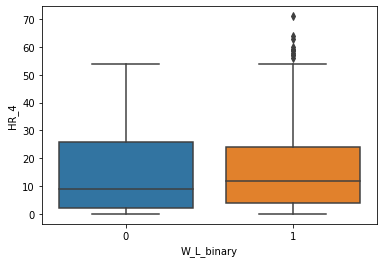

In [64]:
sns.boxplot(y = "HR_4", x = "W_L_binary", data = train)

<AxesSubplot:xlabel='W_L_binary', ylabel='Decel_4'>

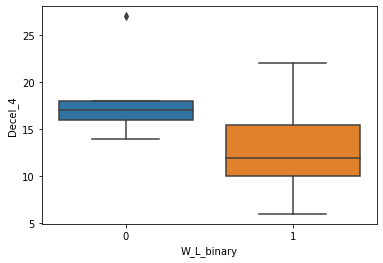

In [66]:
sns.boxplot(y = "Decel_4", x = "W_L_binary", data = train_game_F)

In [28]:
train_game_B = train[(train["Session"] == "Game")&(train["Position"] == "B")]
train_game_B.corrwith(train_game_B.W_L_binary).sort_values(ascending = False)

W_L_binary         1.000000
HR_2               0.171404
Decel_1            0.146810
Max_Speed          0.143344
HR_3               0.139845
Accel_1            0.112939
TLScore_Chronic    0.069957
Recovery           0.065772
Chronic_TD         0.062991
Duration_(min)     0.058751
Calories           0.056564
TRIMP              0.055899
Speed_4            0.046299
HR_Max_Per         0.041698
HR_Max             0.034122
Accel_2            0.032669
Chronic_HR_Sum     0.031759
Cardio_Load        0.027166
Chronic_HIA        0.026879
Decel_2            0.026694
TLScore            0.023433
HR_5               0.018490
Acute_HIA          0.017220
HR_AVG             0.006362
HSD                0.003693
HR_1               0.003302
Speed_1            0.001728
HR_Avg_Per        -0.002147
Speed_3           -0.003498
Total_Distance    -0.006274
Speed_2           -0.010365
Accel_3           -0.011553
HIA               -0.016058
Accel_4           -0.024446
Decel_4           -0.030917
Chronic_Decel     -0

## sort in order of date, then use n/a to fill in

In [29]:
train.sort_values(by='Date', inplace=True) 
train['W_L'].fillna(method='ffill', inplace=True)
train['W_L'].isna().sum()
train['W_L_binary'] = train['W_L'].apply(lambda x: 0 if x=='L' else 1)
train.corrwith(train.W_L_binary).sort_values(ascending = False)

W_L_binary         1.000000
TLScore_Chronic    0.086284
Chronic_TD         0.075295
HR_AVG             0.072445
HR_Avg_Per         0.072317
HR_3               0.063470
Chronic_HR_Sum     0.060087
HR_Max_Per         0.059672
Recovery           0.059574
HR_Max             0.059298
Acute_HIA          0.058933
Chronic_HIA        0.057719
TLScore_Acute      0.053843
Decel_2            0.050194
Chronic_Decel      0.042045
Acute_TD           0.035955
Acute_Decel        0.035569
Max_Speed          0.033941
Accel_1            0.032235
Accel_4            0.031671
Accel_2            0.031380
HIA                0.031253
Week               0.030834
TLScore            0.029710
Accel_3            0.029631
Speed_5            0.026633
Acute_HR_Sum       0.025240
HR_2               0.023421
Cardio_Load        0.023264
TLScore_TSB        0.022454
HR_4               0.020791
Calories           0.020769
Sprints            0.019944
TSB_TD             0.017991
HSD                0.016044
TRIMP              0

<AxesSubplot:xlabel='W_L_binary', ylabel='TLScore_Chronic'>

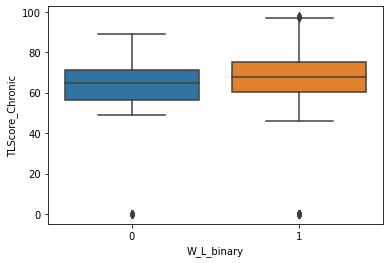

In [87]:
sns.boxplot(y = "TLScore_Chronic", x = "W_L_binary", data = train)

<AxesSubplot:xlabel='W_L_binary', ylabel='HR_AVG'>

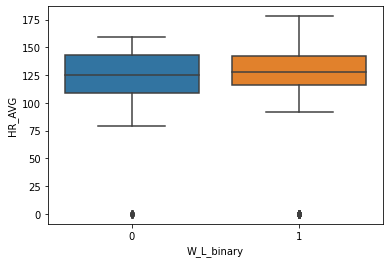

In [88]:
sns.boxplot(y = "HR_AVG", x = "W_L_binary", data = train)

In [30]:
train.Date.value_counts()

2022-08-25    18
2022-09-27    18
2022-09-13    18
2022-09-07    17
2022-09-28    17
              ..
2022-10-22     3
2022-09-20     3
2022-09-19     3
2022-10-17     3
2022-09-12     3
Name: Date, Length: 88, dtype: int64

In [31]:
date_range = pd.date_range('08/25/2022','11/20/2022')
date_range = pd.DataFrame(date_range)
TF_date_range = date_range.isin(train.Date)
date_range

,0
0,2022-08-25
1,2022-08-26
2,2022-08-27
3,2022-08-28
4,2022-08-29
...,...
83,2022-11-16
84,2022-11-17
85,2022-11-18
86,2022-11-19


In [32]:
#i = 0
date_range = pd.date_range('08/25/2022','11/20/2022')
#train.loc[train.Date.isin(train.Date)]
date_range.isin(train.Date)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [91]:
15*29+30

465

**Use forward selection and where BIC is minimum**
**Also use whether the previous game is a win or loss.**
**How many days ago was the previous game - another term.**
**Now do inference, see which predictors actually help see.**
**Make inference on logistic regression. - magnitude of coefficient will give you the odds of winning.**

In [33]:
grouped_train = train.groupby(['Date','Position'])
#print(grouped_train.size().to_string())
gtrain_date_pos = grouped_train.mean()
gtrain_date_pos

Week     HR_Min      HR_AVG      HR_Max  HR_Min_Per  \
Date       Position                                                        
2022-08-25 B         53.0  74.500000  123.500000  179.000000   37.000000   
           F         53.0  82.000000  124.000000  200.500000   41.000000   
           M         53.0  59.583333  129.166667  197.000000   30.000000   
2022-08-26 B         53.0  61.000000  115.000000  178.000000   30.500000   
           F         53.0  78.000000  122.000000  183.000000   39.000000   
...                   ...        ...         ...         ...         ...   
2022-11-19 F         65.0  70.000000  109.000000  190.000000   35.000000   
           M         65.0  43.166667  108.666667  199.000000   21.833333   
2022-11-20 B         65.0  84.500000  146.000000  194.000000   42.000000   
           F         65.0  58.000000  154.000000  202.000000   29.000000   
           M         65.0  42.666667  145.833333  206.166667   21.500000   

                     HR_Avg_Per  HR_Max_Per       HR_1       HR_2       HR_3  \
Date       Position                                                            
2022-08-25 B          61.250000   88.750000  27.500000  14.750000  13.500000   
           F          62.500000  101.500000  34.500000  20.500000   8.000000   
           M          64.916667   98.833333  23.333333  19.166667  13.416667   
2022-08-26 B          57.000000   88.000000  34.000000  14.500000  15.000000   
           F          62.000000   92.000000  43.000000  16.000000  13.000000   
...                         ...         ...        ...        ...        ...   
2022-11-19 F          55.000000   96.000000  28.000000  15.000000  10.000000   
           M          54.333333   99.833333  22.500000  12.333333   7.500000   
2022-11-20 B          72.500000   96.000000  22.000000  24.000000  23.000000   
           F          78.000000  102.000000  10.000000  31.000000  24.000000   
           M          73.166667  103.500000  18.833333  28.833333  22.166667   

                     ...  Chronic_HIA          HSD   Acute_HSD  Chronic_HSD  \
Date       Position  ...                                                      
2022-08-25 B         ...    32.725000   405.750000  272.650000   260.145000   
           F         ...    38.460000   350.000000  260.610000   276.110000   
           M         ...    37.215000   410.250000  324.761667   293.058333   
2022-08-26 B         ...    32.435000   266.500000  280.890000   256.410000   
           F         ...    38.120000   238.000000  252.040000   270.770000   
...                  ...          ...          ...         ...          ...   
2022-11-19 F         ...    32.880000    76.000000  301.140000   327.470000   
           M         ...    34.893333   162.500000  364.363333   375.616667   
2022-11-20 B         ...    31.705000  1450.000000  371.465000   371.065000   
           F         ...    32.530000  1043.000000  328.500000   331.350000   
           M         ...    34.801667  1611.833333  396.076667   387.156667   

                      Decel_Sum  Acute_Decel  Chronic_Decel       TRIMP  \
Date       Position                                                       
2022-08-25 B          43.000000    29.925000      32.010000  473.797500   
           F          46.500000    32.500000      32.660000  483.085000   
           M          38.000000    31.476667      31.048333  495.518333   
2022-08-26 B          37.500000    30.255000      31.930000  488.430000   
           F          26.000000    30.180000      32.550000  518.160000   
...                         ...          ...            ...         ...   
2022-11-19 F          24.000000    26.210000      27.830000  418.970000   
           M          32.166667    30.960000      31.470000  417.688333   
2022-11-20 B         123.000000    33.125000      33.080000  888.165000   
           F          86.000000    27.500000      27.810000  936.830000   
           M         108.500000    32.021667      31.420000  88

In [34]:
gtrain_date_pos

Week     HR_Min      HR_AVG      HR_Max  HR_Min_Per  \
Date       Position                                                        
2022-08-25 B         53.0  74.500000  123.500000  179.000000   37.000000   
           F         53.0  82.000000  124.000000  200.500000   41.000000   
           M         53.0  59.583333  129.166667  197.000000   30.000000   
2022-08-26 B         53.0  61.000000  115.000000  178.000000   30.500000   
           F         53.0  78.000000  122.000000  183.000000   39.000000   
...                   ...        ...         ...         ...         ...   
2022-11-19 F         65.0  70.000000  109.000000  190.000000   35.000000   
           M         65.0  43.166667  108.666667  199.000000   21.833333   
2022-11-20 B         65.0  84.500000  146.000000  194.000000   42.000000   
           F         65.0  58.000000  154.000000  202.000000   29.000000   
           M         65.0  42.666667  145.833333  206.166667   21.500000   

                     HR_Avg_Per  HR_Max_Per       HR_1       HR_2       HR_3  \
Date       Position                                                            
2022-08-25 B          61.250000   88.750000  27.500000  14.750000  13.500000   
           F          62.500000  101.500000  34.500000  20.500000   8.000000   
           M          64.916667   98.833333  23.333333  19.166667  13.416667   
2022-08-26 B          57.000000   88.000000  34.000000  14.500000  15.000000   
           F          62.000000   92.000000  43.000000  16.000000  13.000000   
...                         ...         ...        ...        ...        ...   
2022-11-19 F          55.000000   96.000000  28.000000  15.000000  10.000000   
           M          54.333333   99.833333  22.500000  12.333333   7.500000   
2022-11-20 B          72.500000   96.000000  22.000000  24.000000  23.000000   
           F          78.000000  102.000000  10.000000  31.000000  24.000000   
           M          73.166667  103.500000  18.833333  28.833333  22.166667   

                     ...  Chronic_HIA          HSD   Acute_HSD  Chronic_HSD  \
Date       Position  ...                                                      
2022-08-25 B         ...    32.725000   405.750000  272.650000   260.145000   
           F         ...    38.460000   350.000000  260.610000   276.110000   
           M         ...    37.215000   410.250000  324.761667   293.058333   
2022-08-26 B         ...    32.435000   266.500000  280.890000   256.410000   
           F         ...    38.120000   238.000000  252.040000   270.770000   
...                  ...          ...          ...         ...          ...   
2022-11-19 F         ...    32.880000    76.000000  301.140000   327.470000   
           M         ...    34.893333   162.500000  364.363333   375.616667   
2022-11-20 B         ...    31.705000  1450.000000  371.465000   371.065000   
           F         ...    32.530000  1043.000000  328.500000   331.350000   
           M         ...    34.801667  1611.833333  396.076667   387.156667   

                      Decel_Sum  Acute_Decel  Chronic_Decel       TRIMP  \
Date       Position                                                       
2022-08-25 B          43.000000    29.925000      32.010000  473.797500   
           F          46.500000    32.500000      32.660000  483.085000   
           M          38.000000    31.476667      31.048333  495.518333   
2022-08-26 B          37.500000    30.255000      31.930000  488.430000   
           F          26.000000    30.180000      32.550000  518.160000   
...                         ...          ...            ...         ...   
2022-11-19 F          24.000000    26.210000      27.830000  418.970000   
           M          32.166667    30.960000      31.470000  417.688333   
2022-11-20 B         123.000000    33.125000      33.080000  888.165000   
           F          86.000000    27.500000      27.810000  936.830000   
           M         108.500000    32.021667      31.420000  88

In [35]:
gtrain_date_pos.columns

Index(['Week', 'HR_Min', 'HR_AVG', 'HR_Max', 'HR_Min_Per', 'HR_Avg_Per',
       'HR_Max_Per', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'Total_Distance',
       'Distance/min', 'Max_Speed', 'Avg_Speed', 'Sprints', 'Speed_1',
       'Speed_2', 'Speed_3', 'Speed_4', 'Speed_5', 'Decel_4', 'Decel_3',
       'Decel_2', 'Decel_1', 'Accel_1', 'Accel_2', 'Accel_3', 'Accel_4',
       'Calories', 'TLScore', 'Cardio_Load', 'Recovery', 'TLScore_Acute',
       'TLScore_Chronic', 'TLScore_TSB', 'Acute_HR_Sum', 'Chronic_HR_Sum',
       'TSB_HR_Sum', 'Acute_TD', 'Chronic_TD', 'TSB_TD', 'HIA', 'Acute_HIA',
       'Chronic_HIA', 'HSD', 'Acute_HSD', 'Chronic_HSD', 'Decel_Sum',
       'Acute_Decel', 'Chronic_Decel', 'TRIMP', 'Duration_(min)',
       'W_L_binary'],
      dtype='object')

In [36]:
gtrain_date_pos.columns()

TypeError: 'Index' object is not callable

In [37]:
gtrain_date_pos['Position'].value_counts()

KeyError: 'Position'

In [ ]:
#print(list(gtrain_date_pos.index.value_counts()))
#a = gtrain_date_pos.reset_index(inplace=True)
gtrain_date_pos.Date.value_counts(ascending = True).head(30)

## once we r here

1. run corr, decide which vars to keep and what to drop
2. shift the data by 4 days (have to shift by index bc some of the dates to not have data for all 3 positions)
3. run the logit regression 

In [38]:
pd.Timedelta(days=1)
pd.Timedelta(days=2)
pd.Timedelta(days=3)
pd.Timedelta(days=4)
train[train['Date'] == #gameday date - pd.Timedelta(days=1)]
#not sure if it works but it's worth a shot


mask = df['date1'] == df['one_day_prior']
selected_rows = df[mask]
      
#train['Date']=train['Date'].shift(4*1) #(different numbers?)
#train.tail()

SyntaxError: invalid syntax (3432225002.py, line 9)

In [ ]:
example_model1 = sm.logit(formula = 'W_L~HR_AVG', data = train).fit()

In [40]:
example_model2 = sm.logit(formula = 'W_L~HR_AVG + Calories', data = train).fit()
#sns.scatterplot(x = model. , y = model. )
#sns.lineplot(x = '', y = model.predict(train), data = train)


ValueError: endog has evaluated to an array with multiple columns that has shape (731, 2). This occurs when the variable converted to endog is non-numeric (e.g., bool or str).

# we need to apply pd.to_numeric() on the columns to fix the error, I think but not sure if we should fix the shift first/where to do this step

In [ ]:
example_model3 = sm.logit(formula = 'W_L~HR_AVG + Calories + Max_Speed + Total_Distance', data = train).fit()

In [ ]:
example_model4 = sm.logit(formula = 'W_L~HR_AVG + Calories + Max_Speed + Total_Distance + Recovery + Duration_(min) + HR_Ag_Per', data = train).fit()

In [ ]:
example_model5 = sm.logit(formula = 'W_L~HR_AVG + Speed_1 + Speed_2 + Speed_3 + Speed_4 + Accel_1 + Accel_2 + Accel_3 + Accel_4 + Decel_1 + Decel_2 + Decel_3 + Decel_4', data = train).fit()

In [ ]:
example_model6 = sm.logit(formula = 'W_L~HR_AVG + Calories + Max_Speed + Total_Distance + Recovery + Duration_(min) + HR_Ag_PerSpeed_1 + Speed_2 + Speed_3 + Speed_4 + Accel_1 + Accel_2 + Accel_3 + Accel_4 + Decel_1 + Decel_2 + Decel_3 + Decel_4', data = train).fit()

In [ ]:
example_model7 = sm.logit(formula = 'W_L~HR_AVG + I(HR_Avg)**2 + Calories + Max_Speed + Total_Distance + Recovery + Duration_(min) + HR_Ag_PerSpeed_1 + Speed_2 + Speed_3 + Speed_4 + Accel_1 + Accel_2 + Accel_3 + Accel_4 + Decel_1 + Decel_2 + Decel_3 + Decel_4', data = train).fit()

In [ ]:
#interaction term ideas: HR_Avg*Max_Speed, Total_Distance*Max_Speed, Max_Speed*Recovery, HR_2*Decel_1, Recovery*Chronic_TD, HR_Min_Per*HR_Min, Distance/min*Avg_Speed

In [ ]:
#then check strength, can apply I(variablename)**2 and interaction terms. interact Calories*HR_Avg?
#example models 1-6 do not have interaction terms/alterations

In [ ]:

B 69
F 88
M 88

In [78]:
train_F = train[(train["Position"] == "F")]
train_F.Date

0     2022-08-25
9     2022-08-25
18    2022-08-26
27    2022-08-27
36    2022-08-28
         ...    
728   2022-11-14
638   2022-11-17
647   2022-11-18
656   2022-11-19
665   2022-11-20
Name: Date, Length: 84, dtype: datetime64[ns]

In [84]:
import numpy.ma as ma
import datetime as dt
from scipy.stats.stats import pearsonr, normaltest
from scipy.spatial.distance import correlation
import statsmodels.api as sm
def build_model(features):
  X=sm.add_constant(train_F[features])
  y=train_F['W_L_binary']
  model = smf.logit(y,X, missing='drop').fit()
  predictions = model.predict(X) 
  display(model.summary()) 
  res=y-predictions
  return res 

def build_model_filtered(features, prediction_date):
  X=sm.add_constant(train_F.loc[train_F.Date<prediction_date][features])
  y=train_F.loc[train_F.Date<prediction_date]['W_L_binary']
  model = smf.logit(y,X, missing='drop').fit()
  predictions = model.predict(X) 
  #display(model.rsquared) 
  res=y-predictions
  return res, model

In [85]:
datelist = pd.date_range(dt.datetime(2022, 8, 25), periods=88)

In [86]:
sse = 0
prediction = pd.Series()
train_F['lag_1_day']=train_F['Date'].shift(1)
train_F['lag_2_day']=train_F['Date'].shift(2)
train_F['lag_3_day']=train_F['Date'].shift(3)
train_F['lag_4_day']=train_F['Date'].shift(4)


for i in range(4):
    res, model=build_model_filtered(["HR_4", 'lag_1_day', "lag_2_day", "lag_3_day", "lag_4_day"],datelist[i])
    df_test = train_F.loc[train_F.Date==datelist[i],:]
    prediction = model.predict(sm.add_constant(df_test[["HR_4", 'lag_1_day', "lag_2_day", "lag_3_day", "lag_4_day"]]))
    prediction = pd.concat([prediction, prediction_temp])
    sse = sse+((prediction - df_test['power'])**2).sum()

train_F

/var/folders/j_/vxxst5h10rs21qx29q6pl7bh0000gn/T/ipykernel_22160/3917249926.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prediction = pd.Series()
/var/folders/j_/vxxst5h10rs21qx29q6pl7bh0000gn/T/ipykernel_22160/3917249926.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_F['lag_1_day']=train_F['Date'].shift(1)
/var/folders/j_/vxxst5h10rs21qx29q6pl7bh0000gn/T/ipykernel_22160/3917249926.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

PatsyError: model is missing required outcome variables